# Optimisers

This notebook experiments with the different optimisation algorithms implemented in Keras, and the effect of their various setting.

For visualisation purposes we will not train any networks at all this time, but look at some classic two-dimensial numerical optimisation problems. This means we cannot use Keras' `model.fit()` function, but we will instead write an optimisation loop ourselves. This has the added benefit of showing us exactly the steps involved in doing gradient descent.

The different optimisers we will look at are described in the Keras [documentation](https://keras.io/api/optimizers/). They are all based on computing gradients and stepping in the downwards direction, but apply some tweaks in how the next step is computed.

The regular imports:

In [1]:
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

### Optimisation problems

When we say optimisation problems, technically we mean _minimisation_ -- since our task in deep learning is to find the smallest possible prediction error.

Here we define two diffent functions where the minimum point is somewhat difficult to find. There exists more difficult problems too, just have a look at this [Wikipedia page](https://en.wikipedia.org/wiki/Test_functions_for_optimization) for a list of other ones.

In [2]:
# Rosenbrock function
def rosen(x, y):
	return (1-x)**2 + 100*(y - x**2)**2

# Beale function
def beale(x, y):
	return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x - x*y**3)**2


# Some reasonable bounds and starting points for the functions above
settings_rosen = {
	'xmin': -2,
	'xmax': 2,
	'ymin': -2,
	'ymax': 2,
	'xstart': 0,
	'ystart': 0,
	'xsolution': 1,
	'ysolution': 1
}
settings_beale = {
	'xmin': -5,
	'xmax': 5,
	'ymin': -5,
	'ymax': 5,
	'xstart': -2,
	'ystart': -3,
	'xsolution': 3,
	'ysolution': 0.5
}

### Gradient descent optimisation

Let's get straight to defining our gradient descent function.

We are solving a two-dimensial problem, so we will declare two variables to be optimised, `x` and `y`. We give them some fixed starting values now, but typically one just starts at a random point.

When training a neural network, the steps below are identical, the only difference is that we have more parameters. So try to understand what is going on here, before moving on.

In [7]:
def run_optimisation(optimizer, objective, settings, steps=250, verbose=False):


    # We are trying to do an optimization to the Beale or Rosenbrock functions
    # Which means, find the x and y that provides the smallest z. Or,
    # f'(x,y) = 0 (df/dx, df/dy) = 0
    # Variables to optimize
    x = tf.Variable(float(settings['xstart']), name='x')
    y = tf.Variable(float(settings['ystart']), name='y')

    # Log the values after each step
    # We are logging how close f(x,y) is to the minimum in each step
    values_per_step = [
        [x.numpy(), y.numpy(), objective(x.numpy(), y.numpy())]
    ]
    # For each of the 250 steps, we are preparing the
    for step in range(steps):
            # Tensorflow tool that records operations for auto differentiation.
            # Calculates gradients
        with tf.GradientTape() as tape:

            # Compute the value of our objective function
            loss_value = objective(x, y)

        # Use the GradientTape to automatically retrieve
        # the gradients of the trainable variables with respect to the objective
        grads = tape.gradient(loss_value, [x, y])

        # Print numbers for this step
        if verbose:
            print(f'Step {step}: x = {x.numpy()}, y = {y.numpy()}, gradients: {[g.numpy() for g in grads]}')

        # Step to the next point by applying the gradients
        # (adjusting the weights)
        optimizer.apply_gradients(zip(grads, [x, y]))

        # Log values for this step
        values_per_step.append([x.numpy(), y.numpy(), objective(x.numpy(), y.numpy())])

    # Return the results
    return np.array(values_per_step)


To evaluate the results of our experiments, we define a function to show the steps of the gradient descent procedure, along with the solution.

In the real world we of course do not know the solution, so this is an idealised exercise :)

In [5]:
def plot_optimisation_result(results, objective, settings):

    assert len(results.shape) == 2, '\'results\' should have shape (num_steps, 3)'

    # Make our grid of x and y values
    delta = 0.01
    xaxis = np.arange(settings['xmin'], settings['xmax'], delta)
    yaxis = np.arange(settings['ymin'], settings['ymax'], delta)
    xs, ys = np.meshgrid(xaxis, yaxis)

    # Compute the objective function value at all grid points
    z = objective(xs, ys)

    # Plot contour (surface) of the function
    plt.contourf(xs, ys, np.log(z), cmap='viridis_r', levels=100)

    # Plot the solution
    plt.axvline(settings['xsolution'], c='gray', linewidth=0.5)
    plt.axhline(settings['ysolution'], c='gray', linewidth=0.5)

    # Plot the optimiser steps
    plt.scatter(results[:,0], results[:,1], c='red')
    plt.plot(results[:,0], results[:,1], c='red')

### Running gradient descent

Now the experimentation starts. First we need to chose the optimisation algorithm (again, the list of different ones is [here](https://keras.io/api/optimizers/)). We start out with the simplest one, stochatic gradient descent (SGD), which steps in the same exact direction as the gradient.

We also need to specify how long steps we wish to take, which is given by the `learning_rate` parameter.

In [8]:
optimizer = keras.optimizers.SGD(learning_rate=0.001)

result = run_optimisation(optimizer, objective=beale, settings=settings_beale, steps=250, verbose=True)

Step 0: x = -2.0, y = -3.0, gradients: [np.float32(-2863.5), np.float32(-5700.5)]
Step 1: x = 0.8635001182556152, y = 2.70050048828125, gradients: [np.float32(737.72504), np.float32(652.777)]
Step 2: x = 0.1257750391960144, y = 2.0477235317230225, gradients: [np.float32(-6.857939), np.float32(-1.3488839)]
Step 3: x = 0.13263297080993652, y = 2.049072504043579, gradients: [np.float32(-5.4062157), np.float32(-1.1730263)]
Step 4: x = 0.13803918659687042, y = 2.050245523452759, gradients: [np.float32(-4.2513275), np.float32(-1.0146928)]
Step 5: x = 0.14229051768779755, y = 2.051260232925415, gradients: [np.float32(-3.335209), np.float32(-0.8776612)]
Step 6: x = 0.14562572538852692, y = 2.052137851715088, gradients: [np.float32(-2.6103477), np.float32(-0.7621913)]
Step 7: x = 0.14823606610298157, y = 2.0529000759124756, gradients: [np.float32(-2.0380306), np.float32(-0.66671133)]
Step 8: x = 0.1502740979194641, y = 2.0535666942596436, gradients: [np.float32(-1.5869846), np.float32(-0.588851

Let's plot the results and see how well we did:

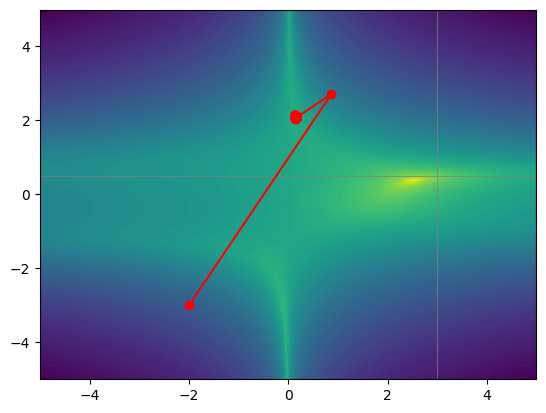

In [9]:
plot_optimisation_result(result, objective=beale, settings=settings_beale)

Hmm. Maybe not great.

We start out with a very long step, so we try again with a smaller learning rate:

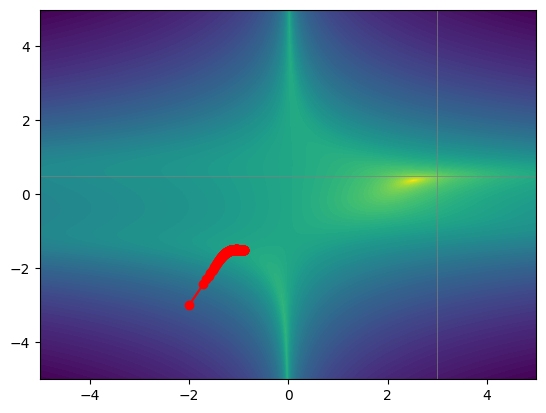

In [10]:
optimizer = keras.optimizers.SGD(learning_rate=0.0001)

# The `verbose` option turns off the output
result = run_optimisation(optimizer, objective=beale, settings=settings_beale, steps=250, verbose=False)
plot_optimisation_result(result, objective=beale, settings=settings_beale)

Better, but apparently the steps are now so small that finding the minimum takes a lot of steps (and potentionally a lot of time).

### <span style="color: red;">Exercise:<span>

Tune the learning rate (and possibly the number of steps) to get closer to the solution.

Step 0: x = -2.0, y = -3.0, gradients: [np.float32(-2863.5), np.float32(-5700.5)]
Step 1: x = -1.427299976348877, y = -1.8598999977111816, gradients: [np.float32(-93.883545), np.float32(-181.30638)]
Step 2: x = -1.4085233211517334, y = -1.823638677597046, gradients: [np.float32(-81.37532), np.float32(-152.69348)]
Step 3: x = -1.392248272895813, y = -1.7930999994277954, gradients: [np.float32(-72.00818), np.float32(-131.0174)]
Step 4: x = -1.377846598625183, y = -1.7668964862823486, gradients: [np.float32(-64.750084), np.float32(-114.04851)]
Step 5: x = -1.364896535873413, y = -1.744086742401123, gradients: [np.float32(-58.974426), np.float32(-100.42092)]
Step 6: x = -1.3531016111373901, y = -1.7240025997161865, gradients: [np.float32(-54.278873), np.float32(-89.250175)]
Step 7: x = -1.3422458171844482, y = -1.7061525583267212, gradients: [np.float32(-50.393383), np.float32(-79.937996)]
Step 8: x = -1.332167148590088, y = -1.6901649236679077, gradients: [np.float32(-47.130135), np.float

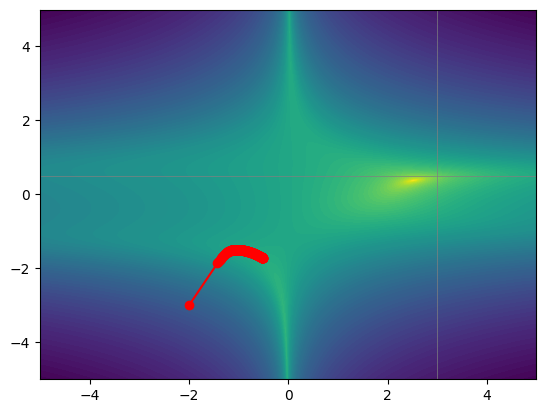

In [16]:
optimizer = keras.optimizers.SGD(learning_rate= 0.0002)

result = run_optimisation(optimizer, objective=beale, settings=settings_beale, steps=300, verbose=True)
plot_optimisation_result(result, objective=beale, settings=settings_beale)

If crancking up the learning rate, you may run into `NaN` (Not-a-Number) or `inf` (infinity) values. This is basically _game over_ for your optimisation progress. The task is now _numerically unstable_, which is reatively common, but can also be very difficult to fix.

It is time to involve more advanced optimisation algorithms.

Step one is to add **momentum**, which in Keras is implemented in the `SDG` class.

### <span style="color: red;">Exercise:<span>

Play with the `momentum` parameter in the code below to find a good solution.

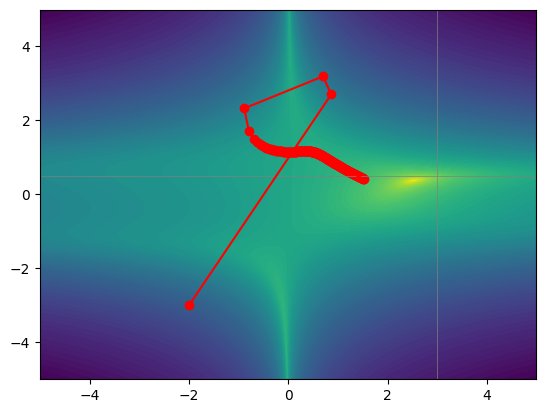

In [17]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.2)

result = run_optimisation(optimizer, objective=beale, settings=settings_beale, steps=250, verbose=False)
plot_optimisation_result(result, objective=beale, settings=settings_beale)

### Better optimisers

Now for the real experiments: Comparing the modern and preferred optimisers such as Adam, RMSprop, and Nadam.


### <span style="color: red;">Exercise:<span>

1) Try out the different possible Keras optimisers.
2) Write an improved plotting function that can show multiple results in the same plot.
3) Use the improved plotting function to compare different settings like `momentum`, `beta`, etc for most or some of the optimisers.
4) (**Optional**:) Implement one of the other optimisation problems listed [here](https://en.wikipedia.org/wiki/Test_functions_for_optimization), and see if the best optimiser for solving the Beal function, is best also for the other problems.